This notebook extracts the lab data and reformat them to have unified denomination. Then extract labels of interest: death and length of stay.

This code relies on [`MIMIC_extract`](https://github.com/MLforHealth/MIMIC_Extract) matching dictionary and the [MIMIC III](https://physionet.org/content/mimiciii/1.4/) data.
To begin, download the data and update the following variable `PATH`.

In [1]:
PATH = '../mimic-iii-clinical-database-1.4/'

In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd

# Lab data

### Mapping labs variables

In [3]:
mapping = pd.read_csv(PATH + 'itemid_to_variable_map.csv', index_col = 'ITEMID', dtype = {'ITEMID': int})
mapping = mapping[(mapping['LEVEL2'] != '') &\
                  (mapping['COUNT'] > 0) &\
                  (mapping['STATUS'] == 'ready')
                 ]

In [4]:
mapping.head()

,LEVEL2,LEVEL1,ALTERNATIVE,STATUS,STATUS NOTE,MIMIC LABEL,UNITNAME,LINKSTO,COUNT,CATEGORY,CONCEPTID,FLUID,LOINC_CODE,DBSOURCE,Unnamed: 15,PARAM_TYPE,NOTE
ITEMID,,,,,,,,,,,,,,,,,
50861,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,ALANINE AMINOTRANSFERASE (ALT),NaN,labevents,219475.0,CHEMISTRY,NaN,BLOOD,,NaN,NaN,NaN,NaN
769,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,ALT,NaN,chartevents,41594.0,Enzymes,NaN,NaN,NaN,carevue,NaN,NaN,NaN
220644,Alanine aminotransferase,Alanine aminotransferase,ALT,ready,NaN,ALT,None,chartevents,37625.0,Labs,NaN,NaN,NaN,metavision,NaN,Numeric,NaN
50862,Albumin,Albumin,NaN,ready,NaN,ALBUMIN,NaN,labevents,146697.0,CHEMISTRY,NaN,BLOOD,1751-7,NaN,NaN,NaN,NaN
772,Albumin,Albumin,NaN,ready,NaN,Albumin (>3.2),NaN,chartevents,31022.0,Chemistry,NaN,NaN,NaN,carevue,NaN,NaN,NaN


### Extract lab data

In [6]:
labs = pd.read_csv(PATH + 'LABEVENTS.csv', parse_dates = ['CHARTTIME'])

In [7]:
# Select data and replace itemid with standard format
labs = labs[labs.ITEMID.isin(mapping.index)][['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'CHARTTIME', 'VALUENUM']]
labs['Lab'] = mapping['LEVEL1'].loc[labs['ITEMID']].values

In [8]:
labs.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUENUM,Lab
0,3,NaN,50820,2101-10-12 16:07:00,7.39,pH
3,3,NaN,50804,2101-10-12 18:17:00,22.00,"CO2 (ETCO2, PCO2, etc.)"
4,3,NaN,50808,2101-10-12 18:17:00,0.93,Calcium ionized
6,3,NaN,50813,2101-10-12 18:17:00,1.80,Lactate
7,3,NaN,50818,2101-10-12 18:17:00,33.00,Partial pressure of carbon dioxide


# Labels

Read the patients' outcome and extract the temporal information for labelling the data

In [9]:
genderAge = pd.read_csv(PATH + 'PATIENTS.csv', usecols = ['SUBJECT_ID', 'GENDER', 'DOB'], parse_dates = ['DOB'])

In [10]:
admissions = pd.read_csv(PATH + 'ADMISSIONS.csv',  
                         usecols = ['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'HOSPITAL_EXPIRE_FLAG',
                                    'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ETHNICITY', 'INSURANCE', 'DIAGNOSIS'],
                         parse_dates = ['ADMITTIME', 'DISCHTIME', 'DEATHTIME'])
admissions = admissions.merge(genderAge, on = 'SUBJECT_ID')

In [11]:
# Focus only on adults - Update 12.10.2021
removed_nan = admissions[['ADMITTIME', 'DOB']].dropna()
admissions['AGE'] = np.nan
admissions['AGE'][removed_nan.index] = [date.days for date in (removed_nan.ADMITTIME.dt.to_pydatetime() - removed_nan.DOB.dt.to_pydatetime())]
admissions.AGE /= 365

admissions = admissions[admissions.AGE > 18]

/var/folders/y2/_2vht5mj2yg3z6bfx5wffnd00000gn/T/ipykernel_74841/3340935559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  admissions['AGE'][removed_nan.index] = [date.days for date in (removed_nan.ADMITTIME.dt.to_pydatetime() - removed_nan.DOB.dt.to_pydatetime())]


In [12]:
# Focus on last visits (as space between visit might change process)
admissions = admissions.loc[admissions['SUBJECT_ID'].drop_duplicates('last').index]

/var/folders/y2/_2vht5mj2yg3z6bfx5wffnd00000gn/T/ipykernel_74841/2422855185.py:2: FutureWarning: In a future version of pandas all arguments of Series.drop_duplicates will be keyword-only.
  admissions = admissions.loc[admissions['SUBJECT_ID'].drop_duplicates('last').index]


In [13]:
# Change times to hours since admission
admissions['Death'] = admissions['DEATHTIME'] - admissions['ADMITTIME']
admissions['LOS'] = admissions['DISCHTIME'] - admissions['ADMITTIME']

In [14]:
# Create index for easier search
admissions = admissions.set_index('SUBJECT_ID')
admissions.head()

,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,GENDER,DOB,AGE,Death,LOS
SUBJECT_ID,,,,,,,,,,,,,,
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,Private,WHITE,BENZODIAZEPINE OVERDOSE,0,F,2131-05-07,64.969863,NaT,1 days 03:28:00
23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,Medicare,WHITE,BRAIN MASS,0,M,2082-07-17,75.304110,NaT,6 days 18:26:00
24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,Private,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,M,2100-05-31,39.041096,NaT,2 days 20:34:00
25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,Private,WHITE,ACUTE CORONARY SYNDROME,0,M,2101-11-21,58.989041,NaT,3 days 12:49:00
26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaT,EMERGENCY,Medicare,UNKNOWN/NOT SPECIFIED,V-TACH,0,M,2054-05-04,72.052055,NaT,6 days 23:44:00


In [15]:
assert len(admissions.HADM_ID.unique()) == len(admissions), \
    "Different patients have the same HADM_ID, might be a problem for the rest of the code"

# Transformation labs

In [16]:
# Remove unecessary HADM_ID
labs = labs[labs.HADM_ID.isin(admissions.HADM_ID)]

In [17]:
# Change time event to time since admission
labs['Time'] = labs.CHARTTIME.values - admissions.ADMITTIME.loc[labs.SUBJECT_ID].values

In [18]:
labs.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUENUM,Lab,Time
160,3,145834.0,50868,2101-10-20 16:40:00,17.0,Anion gap,-1 days +21:32:00
161,3,145834.0,50882,2101-10-20 16:40:00,25.0,Bicarbonate,-1 days +21:32:00
162,3,145834.0,50893,2101-10-20 16:40:00,8.2,Calcium (total),-1 days +21:32:00
163,3,145834.0,50902,2101-10-20 16:40:00,99.0,Chloride,-1 days +21:32:00
166,3,145834.0,50912,2101-10-20 16:40:00,3.2,Creatinine,-1 days +21:32:00


# Reformat

Clean reformating of the dataframe for saving

In [19]:
labs.rename(columns = {"SUBJECT_ID": "Patient",
                       "VALUENUM": "Value"}, inplace = True)
labs = labs.reset_index(drop = True)[['Patient', 'Time', 'Lab', 'Value']]
labs.head()

,Patient,Time,Lab,Value
0,3,-1 days +21:32:00,Anion gap,17.0
1,3,-1 days +21:32:00,Bicarbonate,25.0
2,3,-1 days +21:32:00,Calcium (total),8.2
3,3,-1 days +21:32:00,Chloride,99.0
4,3,-1 days +21:32:00,Creatinine,3.2


In [20]:
admissions.rename_axis(index = "Patient", inplace = True)
admissions.head()

,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,INSURANCE,ETHNICITY,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,GENDER,DOB,AGE,Death,LOS
Patient,,,,,,,,,,,,,,
22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaT,EMERGENCY,Private,WHITE,BENZODIAZEPINE OVERDOSE,0,F,2131-05-07,64.969863,NaT,1 days 03:28:00
23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaT,EMERGENCY,Medicare,WHITE,BRAIN MASS,0,M,2082-07-17,75.304110,NaT,6 days 18:26:00
24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaT,EMERGENCY,Private,WHITE,INTERIOR MYOCARDIAL INFARCTION,0,M,2100-05-31,39.041096,NaT,2 days 20:34:00
25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaT,EMERGENCY,Private,WHITE,ACUTE CORONARY SYNDROME,0,M,2101-11-21,58.989041,NaT,3 days 12:49:00
26,197661,2126-05-06 15:16:00,2126-05-13 15:00:00,NaT,EMERGENCY,Medicare,UNKNOWN/NOT SPECIFIED,V-TACH,0,M,2054-05-04,72.052055,NaT,6 days 23:44:00


# Selection First day

In [21]:
day = 1
first_day = pd.to_timedelta('{} day'.format(day))
admissions = admissions[admissions.LOS >= first_day]
labs = labs[(labs.Time < first_day) & (labs.Time > pd.to_timedelta('0 day')) &\
              labs.Patient.isin(admissions.index)]

# Cleaning labs

In [22]:
# Remove duplicates: same test multiple time at the same time
labs = labs[~labs.set_index(['Patient', 'Time', 'Lab']).index.duplicated(keep = False)]

In [23]:
# Pivot to hae test as columns
labs = labs.pivot(index = ['Patient', 'Time'], columns = 'Lab')

# Change index to have days
labs.index = labs.index.set_levels(labs.index.levels[1].total_seconds()/(3600.*24), 1)

/var/folders/y2/_2vht5mj2yg3z6bfx5wffnd00000gn/T/ipykernel_74841/2743300051.py:5: FutureWarning: In a future version of pandas all arguments of MultiIndex.set_levels except for the argument 'levels' will be keyword-only.
  labs.index = labs.index.set_levels(labs.index.levels[1].total_seconds()/(3600.*24), 1)


In [24]:
# Remove empty lines
labs = labs.dropna(how = 'all')

In [25]:
labs

Value                            \
Lab              Alanine aminotransferase Albumin Albumin (ascites)   
Patient Time                                                          
3       0.002778                      NaN     NaN               NaN   
        0.004167                      NaN     NaN               NaN   
        0.012500                      NaN     NaN               NaN   
        0.035417                     25.0     1.8               NaN   
        0.038889                      NaN     NaN               NaN   
...                                   ...     ...               ...   
99995   0.771528                      NaN     NaN               NaN   
        0.982639                      NaN     NaN               NaN   
99999   0.076389                      NaN     NaN               NaN   
        0.158333                      NaN     NaN               NaN   
        0.996528                      NaN     NaN               NaN   

                                                                       \
Lab              Albumin (pleural) Albumin (urine) Alkaline phosphate   
Patient Time                                                            
3       0.002778               NaN             NaN                NaN   
        0.004167               NaN             NaN                NaN   
        0.012500               NaN             NaN                NaN   
        0.035417               NaN             NaN               73.0   
        0.038889               NaN             NaN                NaN   
...                            ...             ...                ...   
99995   0.771528               NaN             NaN                NaN   
        0.982639               NaN             NaN                NaN   
99999   0.076389               NaN             NaN                NaN   
        0.158333               NaN             NaN                NaN   
        0.996528               NaN             NaN                NaN   

                                                                            \
Lab              Anion gap Asparate aminotransferase Basophils Bicarbonate   
Patient Time                                                                 
3       0.002778       NaN                       NaN       NaN         NaN   
        0.004167       NaN                       NaN       NaN         NaN   
        0.012500      23.0                       NaN       NaN        13.0   
        0.035417      22.0                      69.0       NaN        11.0   
        0.038889       NaN                       NaN       NaN         NaN   
...                    ...                       ...       ...         ...   
99995   0.771528       9.0                       NaN       NaN        32.0   
        0.982639       NaN                       NaN       NaN         NaN   
99999   0.076389       NaN                       NaN       NaN         NaN   
        0.158333       NaN                       NaN       NaN         NaN   
        0.996528       NaN                       NaN       NaN         NaN   

                  ...                                 \
Lab               ... Red blood cell count (ascites)   
Patient Time      ...                                  
3       0.002778  ...                            NaN   
        0.004167  ...                            NaN   
        0.012500  ...                            NaN   
        0.035417  ...                            NaN   
        0.038889  ...                            NaN   
...               ...                            ...   
99995   0.771528  ...                            NaN   
        0.982639  ...                            NaN   
99999   0.076389  ...                            NaN   
        0.158333  ...                            NaN   
        0.996528  ...                            NaN   

                                                                             \
Lab              Red blood cell count (pleural) Sodium Sodium

# Clean outcomes

In [26]:
# Remove patients with no labs
admissions = admissions.loc[labs.index.get_level_values(0).unique()]

In [27]:
admissions['Death'] = admissions['Death'].dt.total_seconds() / (24 * 60 * 60)

# Save

Rename columns and save all the data and labels

In [28]:
labs.to_csv('data/labs_{}_day.csv'.format(day))
admissions.to_csv('data/outcomes_{}_day.csv'.format(day))


-------

# Clinical Presence Evidence

Compute the number of observations for the different group of interest and compare them using t test.

In [29]:
import scipy.stats

In [30]:
labs = pd.read_csv('data/labs_1_day.csv', index_col = [0, 1], header = [0, 1])
outcomes = pd.read_csv('data/outcomes_1_day.csv', index_col = 0)

outcomes['Death'] = outcomes['Death'] < 8

In [31]:
test_count = labs.groupby('Patient').size()

insurance = (outcomes.INSURANCE == 'Private').replace({False: 'Public', True: 'Private'}).rename('Insurance')
death = outcomes['Death'].replace({False: 'Alive', True: 'Death'}).rename('Outcome')
gender = (outcomes.GENDER == 'F').replace({False: 'Male', True: 'Female'}).rename('Gender')
ethnicity = (outcomes.ETHNICITY.str.contains('BLACK')).replace({False: 'Non Black', True: 'Black'}).rename('Ethnicity')

In [32]:
# Average test per outcome
test_count.groupby(death).mean(), test_count.groupby(death).std(), scipy.stats.ttest_ind(test_count[death == "Alive"], test_count[death == "Death"])

(Outcome
 Alive    5.72161
 Death    7.31309
 dtype: float64,
 Outcome
 Alive    4.765949
 Death    5.454323
 dtype: float64,
 Ttest_indResult(statistic=-15.758655093543293, pvalue=9.172998214360495e-56))

In [33]:
# Average test per sex
test_count.groupby(gender).mean(), test_count.groupby(gender).std(), scipy.stats.ttest_ind(test_count[gender == "Female"], test_count[gender == "Male"])

(Gender
 Female    5.502929
 Male      6.076729
 dtype: float64,
 Gender
 Female    4.575085
 Male      5.004339
 dtype: float64,
 Ttest_indResult(statistic=-11.228978900933079, pvalue=3.2834780301641065e-29))

In [34]:
# Average test per ethnicity
test_count.groupby(ethnicity).mean(), test_count.groupby(ethnicity).std(), scipy.stats.ttest_ind(test_count[ethnicity == 'Black'], test_count[ethnicity == 'Non Black'])

(Ethnicity
 Black        5.094570
 Non Black    5.889363
 dtype: float64,
 Ethnicity
 Black        4.111754
 Non Black    4.881681
 dtype: float64,
 Ttest_indResult(statistic=-8.343775106339313, pvalue=7.446627452812745e-17))

In [35]:
# Average test per insurance
test_count.groupby(insurance).mean(), test_count.groupby(insurance).std(), scipy.stats.ttest_ind(test_count[insurance == 'Public'], test_count[insurance == 'Private'])

(Insurance
 Private    6.166928
 Public     5.658430
 dtype: float64,
 Insurance
 Private    5.119983
 Public     4.670904
 dtype: float64,
 Ttest_indResult(statistic=-9.47093621414537, pvalue=2.93484875700486e-21))

### Evolution

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
sns.set(font_scale = 1.5, rc={"figure.dpi":300, 'savefig.dpi':300})

In [37]:
bins = np.linspace(0, 24, endpoint = True)
evolution = labs.groupby('Patient').apply(lambda x: pd.DataFrame({'Cumulative number tests': np.histogram(24 * x.index.get_level_values('Time'), bins)[0].cumsum(), 'Hour after admission': bins[1:]}))

(1.0, 24.0)

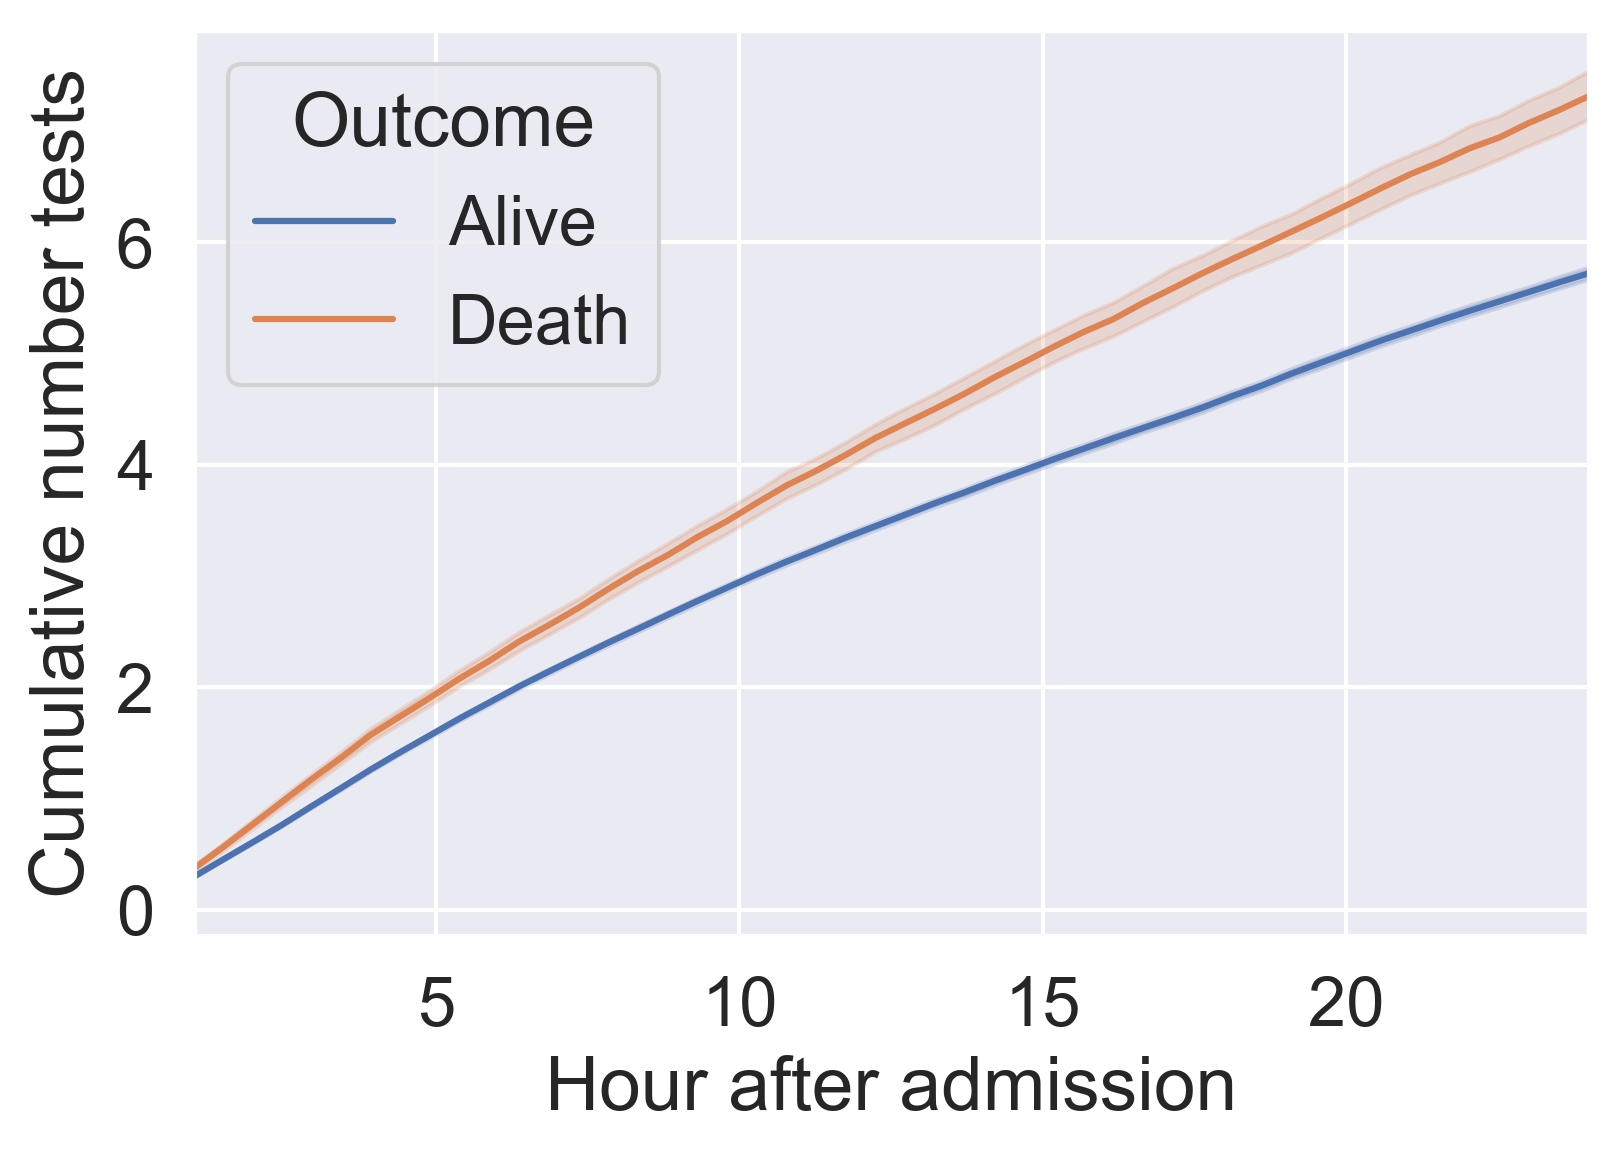

In [38]:
sns.lineplot(data=evolution.join(death), x = "Hour after admission", y = "Cumulative number tests", hue = 'Outcome')
plt.xlim(1, 24)

(1.0, 24.0)

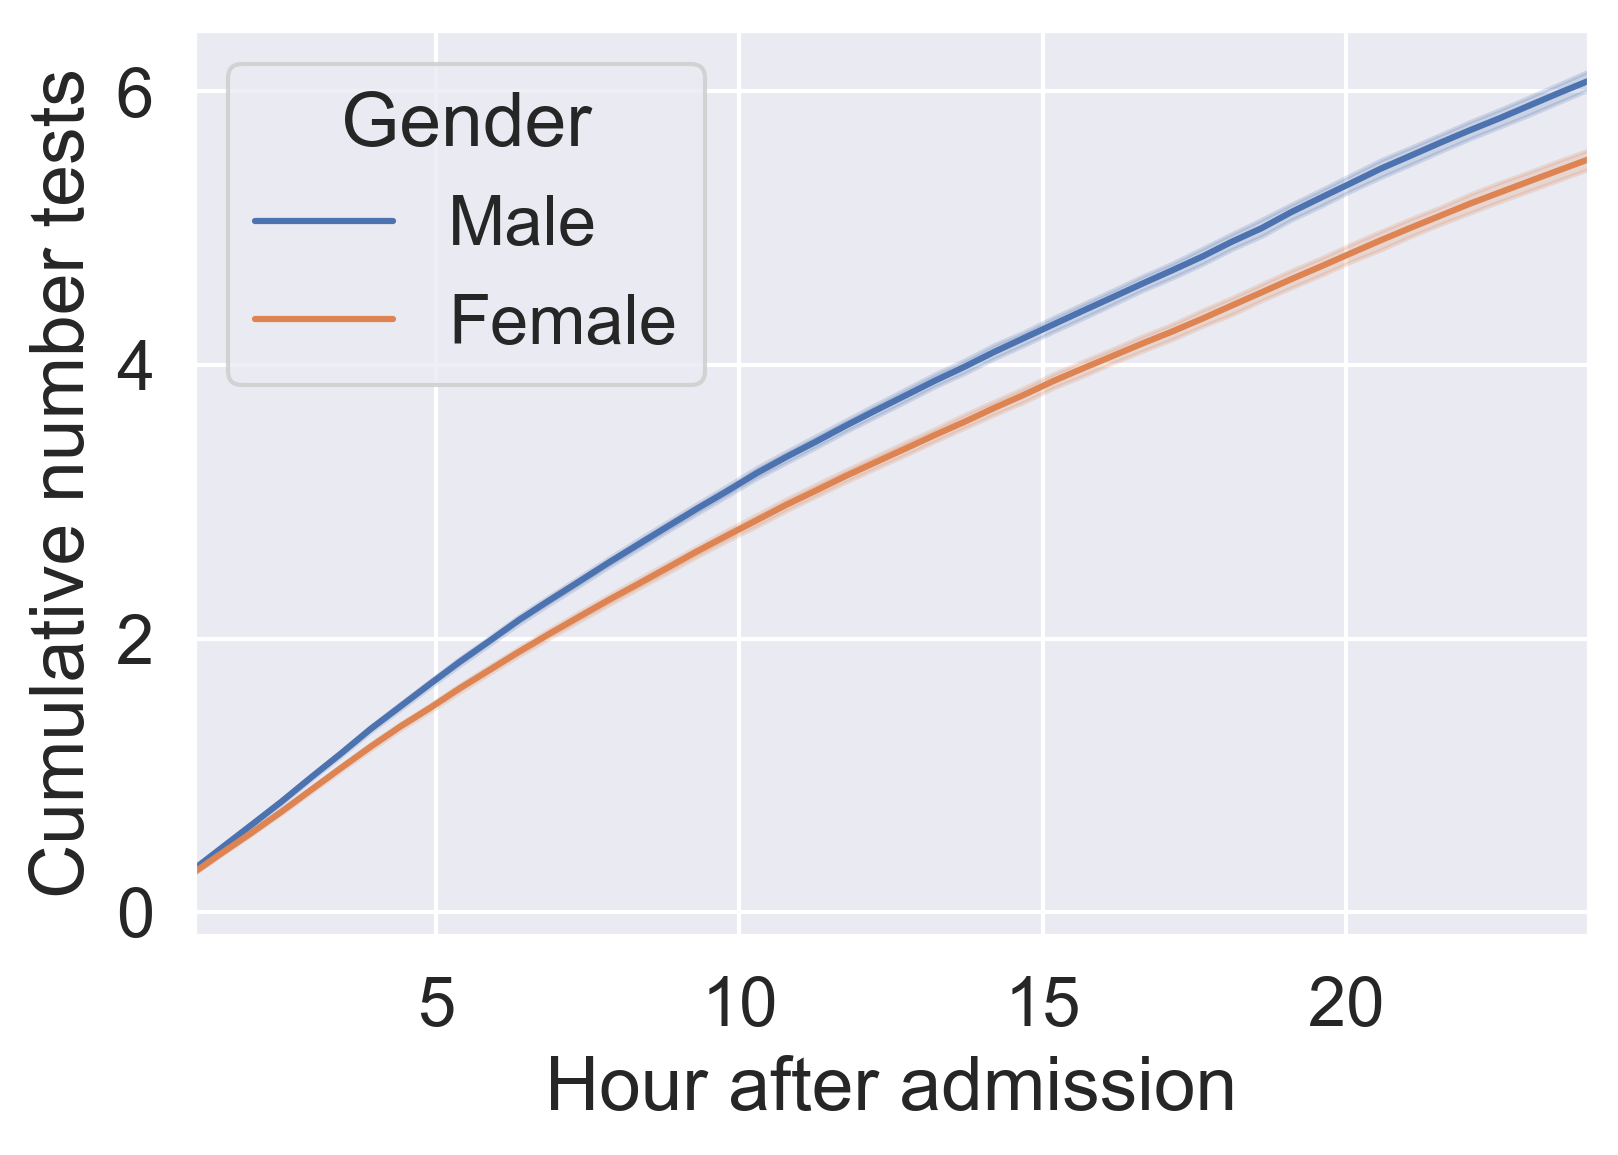

In [39]:
sns.lineplot(data=evolution.join(gender), x = "Hour after admission", y = "Cumulative number tests", hue = 'Gender')
plt.xlim(1, 24)

(1.0, 24.0)

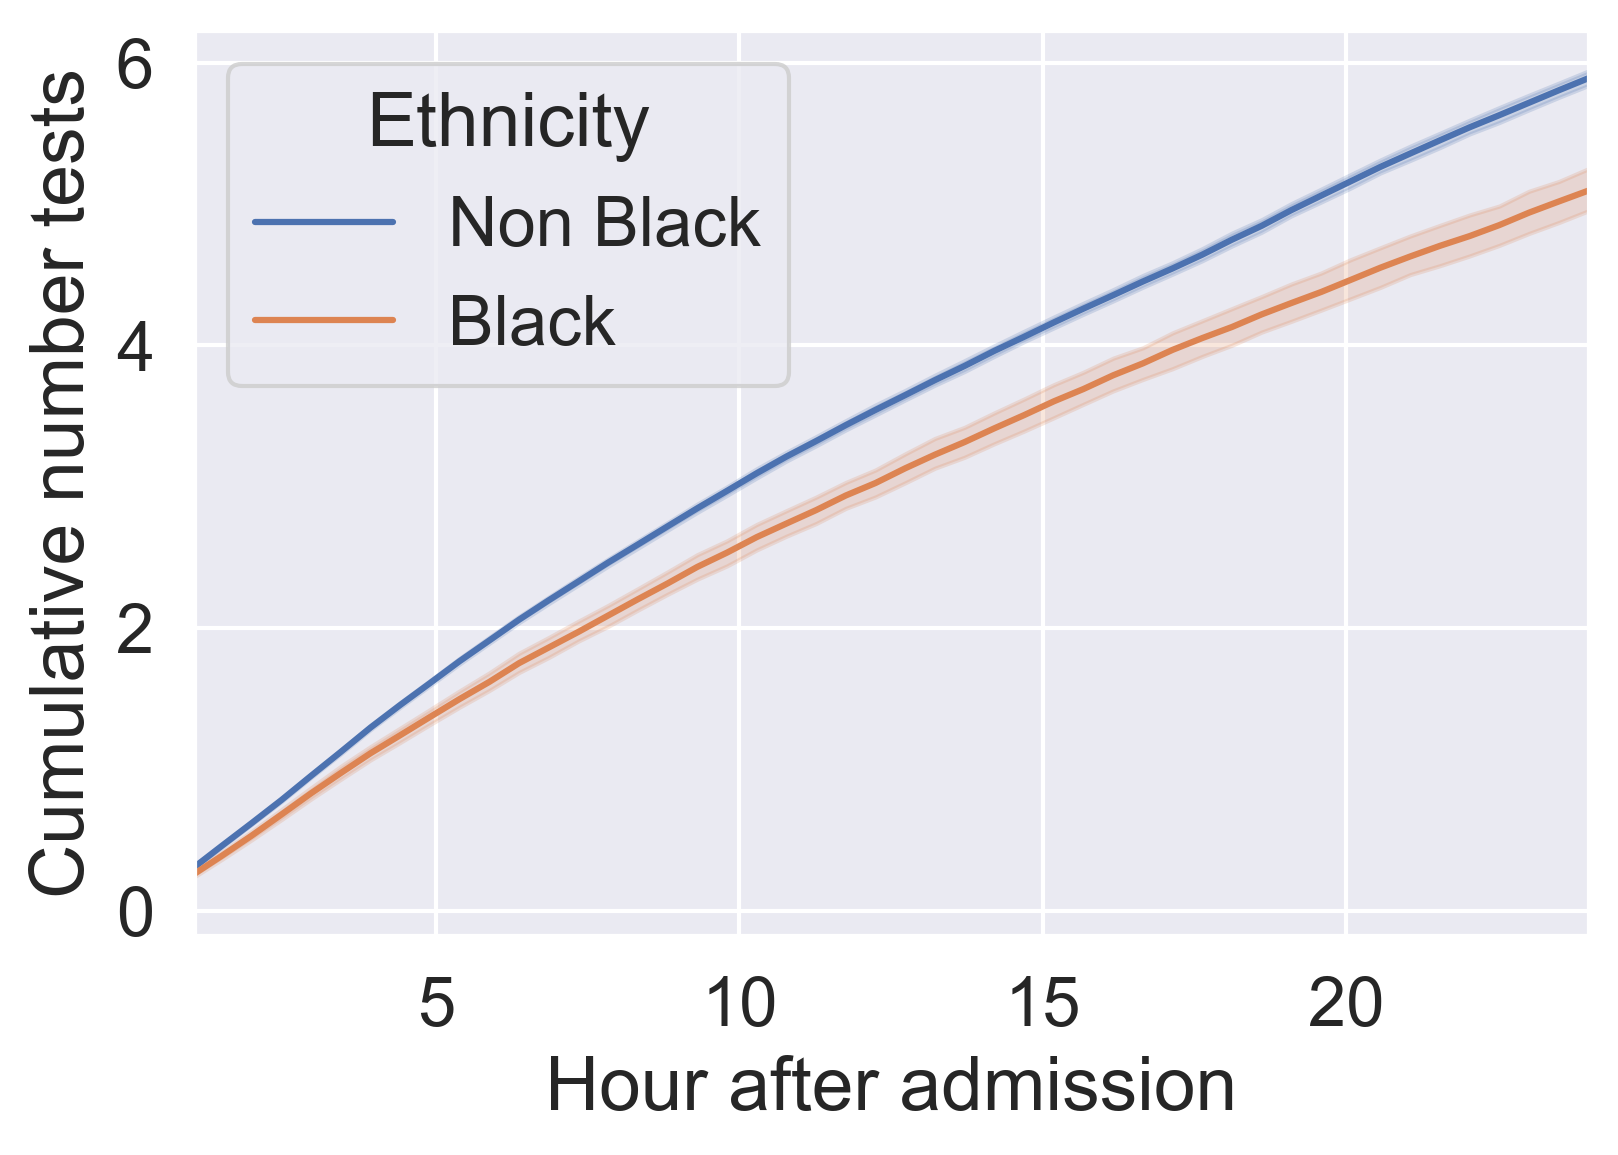

In [40]:
sns.lineplot(data=evolution.join(ethnicity), x = "Hour after admission", y = "Cumulative number tests", hue = 'Ethnicity')
plt.xlim(1, 24)

(1.0, 24.0)

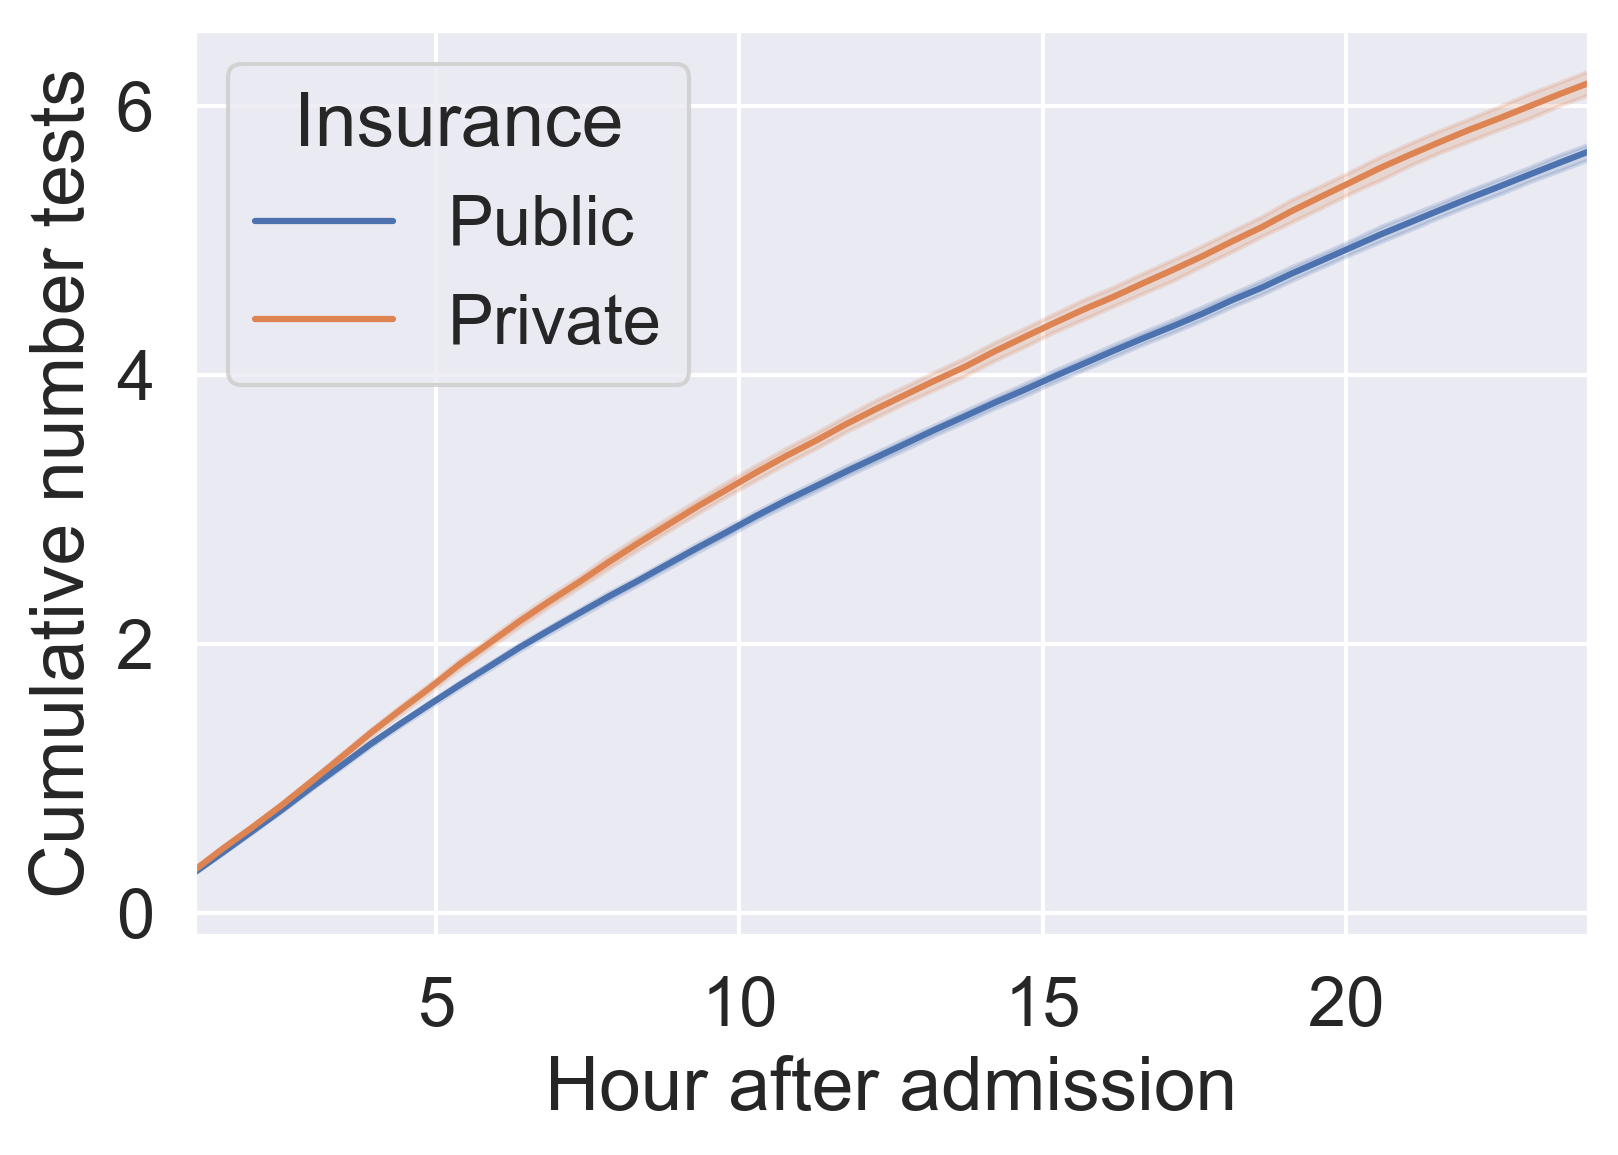

In [41]:
sns.lineplot(data=evolution.join(insurance), x = "Hour after admission", y = "Cumulative number tests", hue = 'Insurance')
plt.xlim(1, 24)